In [18]:
import os
import pickle
import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.tensorboard import SummaryWriter
# %load_ext tensorboard

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1);

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from utils import create_dataloader

In [2]:
data_path = "/global/home/users/xju/projects/herwig/data"
filename = os.path.join(data_path, "allHadrons_10M_mode4_with_quark_with_pert.npz")
org_filename = os.path.join(data_path, "cluster_ML_allHadrons_10M.txt")

# Hadron types

In [25]:
from utils import read_dataframe, split_to_float

In [26]:
df = read_dataframe(org_filename, ";", 'python')
q1,q2,c,h1,h2 = [split_to_float(df[idx]) for idx in range(5)]

In [27]:
h1_type, h2_type = h1[[0]], h2[[0]]

In [28]:
fontsize = 16
def plot_counts(array: np.ndarray):
    types, counts = np.unique(array, return_counts=True)
    num_types = len(types)
    tot_cnts = np.sum(counts)
    xvals = np.arange(num_types)
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(xvals, counts/tot_cnts, s=2.)

    ax.set_xticklabels([])
    ax.set_xlabel("hadron type", fontsize=fontsize)
    print(f"total {num_types} hadrons in the final state")
    return types.astype(np.int64), num_types

total 322 hadrons in the final state


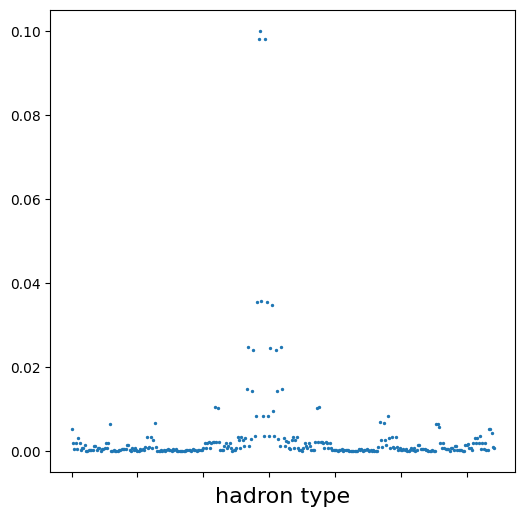

In [29]:
hadron_types = plot_counts(np.concatenate([h1_type, h2_type], axis=0))

## Hadron type embedding

In [30]:
embed_dim = 10
hadron_pids, num_hadron_types = hadron_types
pids_to_ix = {pids: i for i, pids in enumerate(hadron_pids)}

pickle.dump(pids_to_ix, open("pids_to_ix.pkl", "wb"))

In [31]:
type_embedding = nn.Embedding(num_hadron_types, embed_dim)

In [32]:
lookup_tensor = torch.tensor([pids_to_ix[111]], dtype=torch.long)
pion_embed = type_embedding(lookup_tensor)
print(pion_embed)

tensor([[ 0.4865, -0.2672, -0.9057,  1.1978, -1.4437,  0.1671, -0.9476,  0.2961,
         -0.0076, -2.0869]], grad_fn=<EmbeddingBackward0>)


# GAN with hadron type embedding

Read the input data

In [3]:
%%time

batch_size = 10000
num_workers = 6

train_loader, test_loader, xlabels = create_dataloader(filename, batch_size, num_workers)

(78984075, 4) (78984075, 8)
CPU times: user 2min 46s, sys: 1.79 s, total: 2min 47s
Wall time: 2min 48s


Read in the particle index map.

In [4]:
pids_to_ix = pickle.load(open("pids_to_ix.pkl", "rb"))
num_hadron_types = len(list(pids_to_ix.keys()))

In [5]:
batch = next(iter(train_loader))
cond_dim = batch[0].shape[1]
output_dim = batch[1].shape[1] - 2
print("conditional dimension: ", cond_dim)
print("output dimension: ", output_dim)

trained_models = "all_hadron_v1"

conditional dimension:  8
output dimension:  2


In [41]:
def create_MLP_layers(input_dim: int, output_dim: int,
               num_layers: int, hidden_dim: int,
               dropout: float = 0.2,
               layer_norm: bool = True):
    layer_list = []
    for i in range(num_layers):
        if i == 0:
            layer_list.append(torch.nn.Linear(input_dim, hidden_dim))
        else:
            layer_list.append(torch.nn.Linear(hidden_dim, hidden_dim))

        if layer_norm:
            layer_list.append(torch.nn.LayerNorm(hidden_dim))

        layer_list.append(torch.nn.LeakyReLU(0.2))
        if dropout > 0:
            layer_list.append(torch.nn.Dropout(dropout))

    layer_list.append(torch.nn.Linear(hidden_dim, output_dim))
    return layer_list


class Generator(nn.Module):
    """Generator for the GAN"""
    def __init__(self, noise_dim: int, cond_dim: int, output_dim: int,
                 num_hadron_types: int, num_layers: int, hidden_dim: int,
                 num_max_hadrons: int = 2,
                 dropout: float = 0,
                 layer_norm: bool = True,
                ):       
        super(Generator, self).__init__()
        
        layer_list = create_MLP_layers(
            noise_dim + cond_dim,
            output_dim+num_hadron_types*num_max_hadrons,
            num_layers, hidden_dim, dropout)

        self.model = nn.Sequential(*layer_list)
        

    def forward(self, x):
        return self.model(x)
    
    
class Discriminator(torch.nn.Module):
    """Discriminator for the GAN"""
    def __init__(self, input_dim: int, cond_dim: int,
                 num_hadron_types: int, 
                 num_layers: int, hidden_dim: int,
                 num_max_hadrons: int = 2,
                 dropout: float = 0.2,
                 layer_norm: bool = True,
                ):
        super(Discriminator, self).__init__()        
        
        layer_list = create_MLP_layers(
            cond_dim + input_dim +  num_hadron_types * num_max_hadrons,
            1,
            num_layers, hidden_dim, dropout, layer_norm)

        layer_list.append(nn.Sigmoid())
        self.model = torch.nn.Sequential(*layer_list)
        
    
    def forward(self, x):
        return self.model(x)

In [6]:
## HPs for the GAN
noise_dim = 16
num_max_hadrons = 2

In [49]:
generator = Generator(noise_dim, cond_dim, output_dim, num_hadron_types,
                      num_layers=10, hidden_dim=1024,
                      num_max_hadrons=num_max_hadrons).to(device)

discriminator = Discriminator(output_dim, cond_dim, num_hadron_types,
                              num_layers=5, hidden_dim=64,
                              num_max_hadrons=num_max_hadrons, layer_norm=False).to(device)

print(generator)
print(discriminator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=24, out_features=1024, bias=True)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=1024, out_features=1024, bias=True)
    (10): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (11): LeakyReLU(negative_slope=0.2)
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Linear(in_features=1024, out_features=1024, bias=True)
    (16): LayerNorm((1024,), eps=1e-05, elementwise_affine=True

In [36]:
noise = torch.randn(batch_size, noise_dim).to(device)
x, y = batch
x, y = x.to(device), y.to(device)
x_gen = torch.concat([x, noise], dim=1).to(device)

fake = generator(x_gen)

x_disc = torch.cat([x, fake], dim=1).to(device)
score = discriminator(x_disc)

In [9]:
## Loss functions

criterion = nn.BCELoss()


In [50]:
## HPs for training
gen_lr  = 0.00001
disc_lr = 0.00005
beta1 = 0.5   # default value: 0.9

opt_gen = optim.Adam(generator.parameters(), lr=gen_lr, betas=(beta1, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=disc_lr, betas=(beta1, 0.999))


In [54]:
def train():
    real_label = 1
    fake_label = 0
    
    tot_loss_gen = 0
    tot_loss_disc = 0
    num_batches = 0
    for batch in train_loader:
        num_batches += 1
        x, y = batch
        x, y = x.to(device), y.to(device)
        
        ##  Train discriminator with all-real batch
        discriminator.zero_grad()

        target_hadron_types = y[:, 2:].reshape(-1).long()
        target_hadron_types_idx = torch.from_numpy(np.array(
            [pids_to_ix[int(pid)] for pid in target_hadron_types]))
        
        num_evts = y.shape[0]

        true_hadron_types = torch.abs(F.one_hot(target_hadron_types_idx, num_classes=num_hadron_types) \
            - torch.rand(num_evts*num_max_hadrons, num_hadron_types)*0.001).reshape(num_evts, -1).to(device)
        x_truth = torch.cat([x, y[:, :2], true_hadron_types], dim=1)
        score_truth = discriminator(x_truth).squeeze()
        label = torch.full((num_evts,), real_label, dtype=torch.float, device=device)
        loss_real = criterion(score_truth, label)

        loss_real.backward()

        ## Train discriminator with all-fake batch
        noise = torch.randn(num_evts, noise_dim).to(device)
        x_fake = torch.concat([x, noise], dim=1)
        fake = generator(x_fake)

        x_generated = torch.cat([x, fake], dim=1)
        score_fakes = discriminator(x_generated.detach()).squeeze()
        label.fill_(fake_label)
        loss_fake = criterion(score_fakes, label)
        loss_fake.backward()
        loss_disc = loss_real + loss_fake
        ## Update discriminator
        opt_disc.step()


        ## Train generator
        generator.zero_grad()
        label.fill_(real_label)
        score_fakes = discriminator(x_generated).squeeze()
        loss_generator = criterion(score_fakes, label)
        loss_generator.backward()
        opt_gen.step()
        
        tot_loss_gen += loss_generator.item()
        tot_loss_disc += loss_disc.item()
        
        if num_batches > 10000:
            break
        
    return tot_loss_gen/num_batches, tot_loss_disc/num_batches

In [45]:
def train_one_batch(batch):
    real_label = 1
    fake_label = 0
    
    x, y = batch
    x, y = x.to(device), y.to(device)

    ##  Train discriminator with all-real batch
    discriminator.zero_grad()

    target_hadron_types = y[:, 2:].reshape(-1).long()
    target_hadron_types_idx = torch.from_numpy(np.array(
        [pids_to_ix[int(pid)] for pid in target_hadron_types]))

    num_evts = y.shape[0]

    true_hadron_types = torch.abs(F.one_hot(target_hadron_types_idx, num_classes=num_hadron_types) \
        - torch.rand(num_evts*num_max_hadrons, num_hadron_types)*0.001).reshape(num_evts, -1).to(device)
    x_truth = torch.cat([x, y[:, :2], true_hadron_types], dim=1)
    score_truth = discriminator(x_truth).squeeze()
    label = torch.full((num_evts,), real_label, dtype=torch.float, device=device)
    loss_real = criterion(score_truth, label)

    loss_real.backward()

    ## Train discriminator with all-fake batch
    noise = torch.randn(num_evts, noise_dim).to(device)
    x_fake = torch.concat([x, noise], dim=1)
    fake = generator(x_fake)

    x_generated = torch.cat([x, fake], dim=1)
    score_fakes = discriminator(x_generated.detach()).squeeze()
    label.fill_(fake_label)
    loss_fake = criterion(score_fakes, label)
    loss_fake.backward()
    loss_disc = loss_real + loss_fake
    ## Update discriminator
    opt_disc.step()


    ## Train generator
    generator.zero_grad()
    label.fill_(real_label)
    score_fakes = discriminator(x_generated).squeeze()
    loss_generator = criterion(score_fakes, label)
    loss_generator.backward()
    opt_gen.step()
        
    return loss_generator.item(), loss_disc.item()

In [39]:
writer = SummaryWriter()
writer.add_graph(generator, x_gen)
writer.add_graph(discriminator, x_disc)

/global/home/users/xju/miniconda3/envs/pyG-1.12.1/lib/python3.9/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/build/aten/src/ATen/core/TensorBody.h:477.)
  return self._grad


In [51]:
num_epochs = 200
num_batches = len(train_loader)

for _ in tqdm.trange(num_epochs, position=1):
    # training
    with tqdm.tqdm(enumerate(train_loader), desc=f"Epoch {_}", position=0, leave=True, total=num_batches) as t1:
        for bidx,batch in t1:
            loss_gen, loss_disc = train_one_batch(batch)

            metric = dict(lossG=loss_gen, lossD=loss_disc/2)
            t1.set_postfix(metric)


  0%|          | 0/200 [14:46<?, ?it/s]


KeyboardInterrupt: 

In [25]:
torch.save({'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'generator_opt': opt_gen.state_dict(),
            'discriminator_opt': opt_disc.state_dict()
           }, f'{trained_models}.ckpt')

In [ ]:
        # writer.add_scalar("Generator Loss", loss_gen, _)
        # writer.add_scalar("Discriminator Loss", loss_disc, _)
        
            
        
            # validation <TODO>
            # t0.set_postfix(**metric)